In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

# Version 4 - Just like version 3 (best performing so far) - but I'm going to try to have higher res images (512 x 512).  Who cares if it takes longer?

In [2]:
# paths to folders containing images 
pneumonia_folder = 'Resources/train/PNEUMONIA'
healthy_folder = 'Resources/train/NORMAL'

# load images from pneumonia folder
pneumonia_images = [os.path.join(pneumonia_folder, img) for img in os.listdir(pneumonia_folder)]

# load images from healthy folder
healthy_images = [os.path.join(healthy_folder, img) for img in os.listdir(healthy_folder)]

print(pneumonia_images)

print(healthy_images)

['Resources/train/PNEUMONIA\\person1000_bacteria_2931.jpeg', 'Resources/train/PNEUMONIA\\person1000_virus_1681.jpeg', 'Resources/train/PNEUMONIA\\person1001_bacteria_2932.jpeg', 'Resources/train/PNEUMONIA\\person1002_bacteria_2933.jpeg', 'Resources/train/PNEUMONIA\\person1003_bacteria_2934.jpeg', 'Resources/train/PNEUMONIA\\person1003_virus_1685.jpeg', 'Resources/train/PNEUMONIA\\person1004_bacteria_2935.jpeg', 'Resources/train/PNEUMONIA\\person1004_virus_1686.jpeg', 'Resources/train/PNEUMONIA\\person1005_bacteria_2936.jpeg', 'Resources/train/PNEUMONIA\\person1005_virus_1688.jpeg', 'Resources/train/PNEUMONIA\\person1006_bacteria_2937.jpeg', 'Resources/train/PNEUMONIA\\person1007_bacteria_2938.jpeg', 'Resources/train/PNEUMONIA\\person1007_virus_1690.jpeg', 'Resources/train/PNEUMONIA\\person1008_bacteria_2939.jpeg', 'Resources/train/PNEUMONIA\\person1008_virus_1691.jpeg', 'Resources/train/PNEUMONIA\\person1009_virus_1694.jpeg', 'Resources/train/PNEUMONIA\\person100_virus_184.jpeg', 'Reso

In [3]:
# preprocess function
def preprocess_image(image_paths, target_size):
    processed_images = []
    for image_path in image_paths:
        try:
            image = Image.open(image_path)
            # convert RGB image to grayscale - (not sure if I need this but couldn't hurt)
            image = image.convert('L')
            image = image.resize(target_size)
            image = np.array(image)
            processed_images.append(image)
        except Exception as e:
            print(f"Error processing image: {image_path}. Error: {e}")
    return processed_images

In [4]:
# select random subset of images
num_images_to_select = 300
selected_healthy_files = random.sample(healthy_images, num_images_to_select)
selected_pneumonia_files = random.sample(pneumonia_images, num_images_to_select)

X = []
y = []

# define target size
target_size = (512, 512)

# process selected pneumonia images
processed_pneumonia_images = preprocess_image(selected_pneumonia_files, target_size)
X.extend(processed_pneumonia_images)
y.extend([1] * len(processed_pneumonia_images))

# process selected healthy images
processed_healthy_images = preprocess_image(selected_healthy_files, target_size)
X.extend(processed_healthy_images)
y.extend([0] * len(processed_healthy_images))

X = np.array(X).reshape(-1, 512, 512, 1)
y = np.array(y)

# confirm shapes of X and y
print(X.shape, y.shape)

(600, 512, 512, 1) (600,)


In [5]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print shapes of training & testing sets to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (480, 512, 512, 1)
X_test shape: (120, 512, 512, 1)
y_train shape: (480,)
y_test shape: (120,)


In [6]:
# lighten image function
def lighten_image(image, factor=1.5):
    return np.clip(image * factor, 0, 255).astype(np.uint8)

# darken image function
def darken_image(image, factor=0.5):
    return np.clip(image * factor, 0, 255).astype(np.uint8)

# augment data function
def augment_dataset(X_train, y_train):
    augmented_images = []
    augmented_labels = []
    
    for image, label in zip(X_train, y_train):
        original_image = image
        lightened_image = lighten_image(image)
        darkened_image = darken_image(image)
        
        augmented_images.extend([original_image, lightened_image, darkened_image])
        augmented_labels.extend([label, label, label])
    
    X_train_augmented = np.array(augmented_images)
    y_train_augmented = np.array(augmented_labels)
    
    return X_train_augmented, y_train_augmented

In [7]:
# define CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# augment dataset - concatenate lighter and darker images, also triple y_train
X_train_augmented, y_train_augmented = augment_dataset(X_train, y_train)

# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
history = model.fit(X_train_augmented, y_train_augmented, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
45/45 [==============================] - 242s 5s/step - loss: 324.6286 - accuracy: 0.7597 - val_loss: 1.0064 - val_accuracy: 0.9083
Epoch 2/5
45/45 [==============================] - 248s 6s/step - loss: 0.0701 - accuracy: 0.9889 - val_loss: 1.0558 - val_accuracy: 0.9417
Epoch 3/5
45/45 [==============================] - 277s 6s/step - loss: 0.0431 - accuracy: 0.9931 - val_loss: 1.2590 - val_accuracy: 0.9167
Epoch 4/5
45/45 [==============================] - 345s 8s/step - loss: 0.0171 - accuracy: 0.9986 - val_loss: 1.2572 - val_accuracy: 0.9167
Epoch 5/5
45/45 [==============================] - 378s 8s/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.4334 - val_accuracy: 0.9167


In [8]:
# make predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

4/4 [==============================] - 6s 1s/step


In [9]:
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# calculate precision/recall/F1
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# print evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 91.67%
Precision: 0.92
Recall: 0.92
F1 Score: 0.92


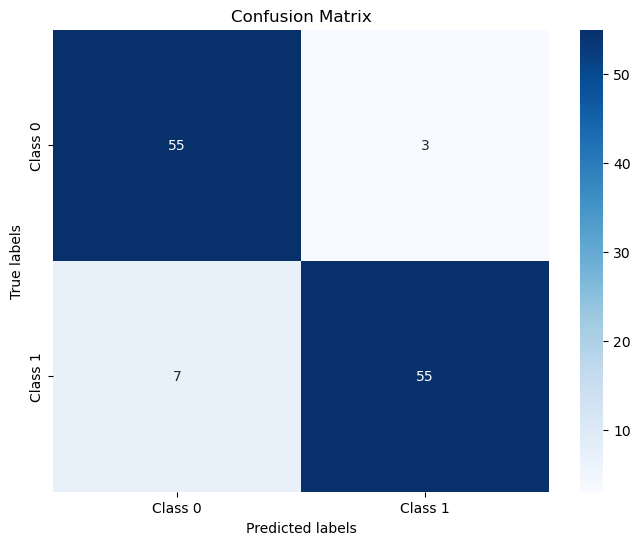

In [10]:
# get confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

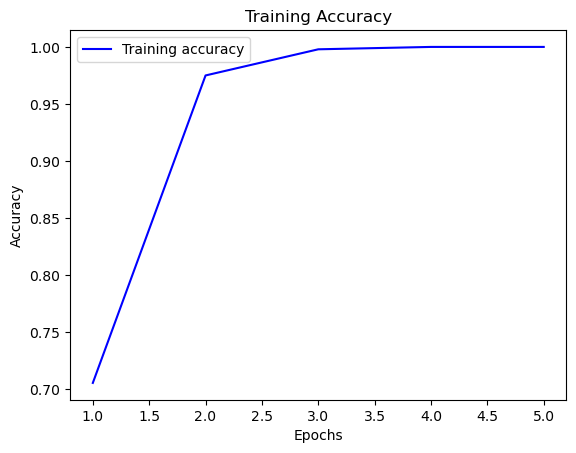

In [23]:
# access accuracy values from history 
accuracy = history.history['accuracy']
epochs = range(1, len(accuracy) + 1)

# plot accuracy over epochs
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()